In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from utils import printProgressBar

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.im_int0 = nn.Linear(784, 256)
        self.int0_mu = nn.Linear(256, 2)
        self.int0_sig = nn.Linear(256, 2)
        self.lat_int1 = nn.Linear(2, 256)
        self.int1_im = nn.Linear(256, 784)
#         self.criterion = nn.MSELoss()
        self.criterion = nn.BCELoss()
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # KICKASS DATALOADER AND PREPROCESSOR IN PYTORCH:

        self.train_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('.',
                                       train=True,
                                       download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor()
                                     ])),
            batch_size=100, shuffle=True)
        
    def forward(self, visual_input, direct_mu=None):
        if direct_mu is None:
            
            int0 = F.relu(self.im_int0(visual_input))

            # we don't activate the output of the im_mu layer, 
            # because we want mu to be in [-Inf, +Inf]
            mu = self.int0_mu(int0)

            # for convenience, we 'ask' the layer to give us not sigma, but log(sigma).
            # because in the loss, we don't need pure sigma, but log(sigma)
            # likewise, we don't activate the output of the im_sig layer because we want
            # log(sigma) to be in [-Inf, +Inf], and consequently sigma to be in [0, +Inf]
            log_sig = self.int0_sig(int0)
        
            # Don't forget to transform log(sigma) back to the linspace before you pass
            # it as an argument to the reparametrization function. Sample one 2D point 
            # from a 2D normal distribution with the given mean and sigma
            # NOTE. The commented line below will not work, because gradients cannot flow through
            # stochastic variables. BUT you can add randomly sampled constants to variables
            # without any problem. This is called the 'reparametrization trick' (see the function reparametrize)
            # latent = torch.normal(mean=mu, std=torch.exp(log_sig)) 
            latent = self.reparameterize(mu, log_sig)
                        
            # sidmoid will transform the ouput of the latent layer,
            # becuase the input and output image intensities are chosen to be in [0, 1]
            int1 = F.relu(self.lat_int1(latent))
            decoded = torch.sigmoid(self.int1_im(int1))
        else:
            int1 = F.relu(self.lat_int1(
                torch.tensor([direct_mu[0], direct_mu[1]], dtype=torch.float).view(-1, 2).to(device)))
            decoded = torch.sigmoid(self.int1_im(int1))
            mu, log_sig = 0, 0
    
        return decoded, mu, log_sig
    
    def reparameterize(self, mu, log_sig):
        std = torch.exp(log_sig)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def KL(self, z_mean, z_log_sigma):
        kl_loss = - 0.5 * torch.sum(1 + z_log_sigma - z_mean.pow(2) - z_log_sigma.exp())
        return kl_loss

    def fit(self, EPOCHS=1000):
        printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)
        self.train()
        
        for epoch in range(EPOCHS):
            try:
                # one epoch consists of several batches, spanning the entire dataset
                for batch_idx, (example_data, example_targets) in enumerate(self.train_loader):
                    example_data = example_data.to(device).view(-1, 784)

                    # don't forget to zero grads after each batch. Gradients accumulate 
                    # for each sample in a batch.
                    self.optimizer.zero_grad() 

                    decoded, mu, log_sig = self.forward(example_data)

                    kl_loss = self.KL(mu, log_sig)
                    xent_loss = F.binary_cross_entropy(decoded, example_data, reduction='sum')
                    loss = kl_loss + xent_loss
    
                    loss.backward()
                    self.optimizer.step()

                    printProgressBar(epoch + 1,
                                     EPOCHS,
                                     prefix='Epoch: {} Dkl: {:.7f}, xent: {:.3f}'.format(
                                         epoch,            
                                         kl_loss.item(),
                                         xent_loss.item()),
                                     suffix='Complete',
                                     length=25)
            except KeyboardInterrupt:
                    print('\nKeyboard Interrupt')
                    break
    
    def evaluate(self, rng, n):
        # display a 2D manifold of the digits
        digit_size = 28
        figure = np.zeros((digit_size * n, digit_size * n))
        # we will sample n points within [-2, 2] standard deviations
        grid_x = np.linspace(rng[0], rng[1], n)
        grid_y = np.linspace(rng[0], rng[1], n)

        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                decoded, mu, sig = vae.forward(0, direct_mu=(xi, yi))
                digit = decoded.cpu().detach().numpy().reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(10, 10))
        plt.imshow(figure)
        plt.show()

In [4]:
vae = VAE().to(device)
x = enumerate(vae.train_loader)
batch_idx, (example_data, example_targets) = next(x)
print('Dataset global minimum: {}'.format(example_data[0,:,:,:].reshape(28,28).min()))
print('Dataset global maximum: {}'.format(example_data[0,:,:,:].reshape(28,28).max()))

Dataset global minimum: 0.0
Dataset global maximum: 0.996078431606


In [5]:
# Fit. Hit stop (Ctrl-C) to interrupt without losing the state.
vae.train()
vae.fit(EPOCHS=10000)

Epoch: 6 Dkl: 340.9844971, xent: 15512.227 |-------------------------| 0.1% Complete
Keyboard Interrupt


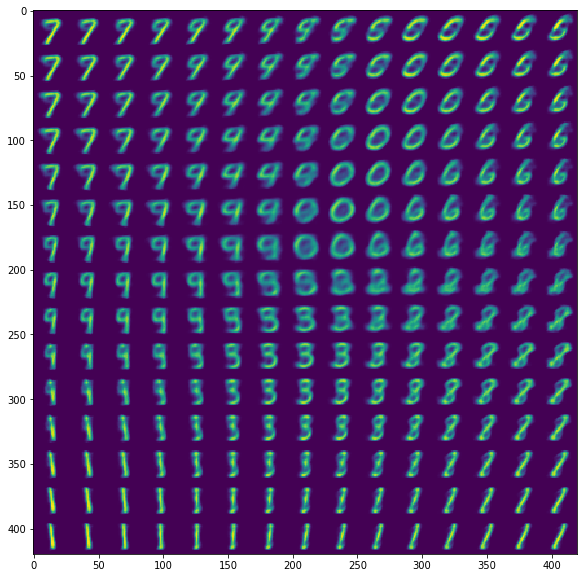

In [6]:
%matplotlib inline
# Evaluate.

rng = (-2,2)
n = 15
vae.eval()
vae.evaluate(rng, n)

In [7]:
MU = torch.linspace(-2, 2, 100)
SIG = torch.linspace(0.01, 5, 100)

A = torch.zeros((100,100))

for i, mu in enumerate(MU):
    for j,sig in enumerate(SIG):
        A[i,j] = vae.KL(mu, np.log(sig))

Text(0.5,1,'KL divergence as a function of $\\mu$ and $\\sigma$\n of distribution Q from the P ~ N(0,1)')

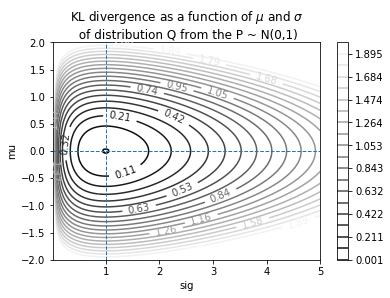

In [8]:
# plt.imshow(A)
# plt.xlabel('sig')
# plt.ylabel('mu')
# plt.colorbar()
import matplotlib.cm as cm

levels = np.linspace(0.001,2,20)
ct = plt.contour(SIG, MU, A, levels, cmap=cm.gray)
plt.xlabel('sig')
plt.ylabel('mu')
plt.colorbar()
plt.clabel(ct,fmt='%1.2f')
plt.axvline(1, linestyle='--', linewidth=1)
plt.axhline(0, linestyle='--', linewidth=1)

plt.title('KL divergence as a function of $\mu$ and $\sigma$\n of distribution Q from the P ~ N(0,1)')